In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pylab import rcParams

from mlforecast import MLForecast
from sklearn.neural_network import MLPRegressor

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

In [32]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)

In [33]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [34]:
df_brl.head()

,ds,y,unique_id
0,2020-01-01,73.428636,ACUCAR_SANTOS
1,2020-02-01,81.636111,ACUCAR_SANTOS
2,2020-03-01,79.906364,ACUCAR_SANTOS
3,2020-04-01,77.113500,ACUCAR_SANTOS
4,2020-05-01,84.638500,ACUCAR_SANTOS


In [35]:
train, val, test = split_series(df_brl)

Treino + Val ACUCAR_SANTOS: 45 | Teste ACUCAR_SANTOS: 20
Treino + Val ACUCAR_SP: 185 | Teste ACUCAR_SP: 80
Treino + Val ALGODAO: 243 | Teste ALGODAO: 105
Treino + Val ARROZ: 168 | Teste ARROZ: 72
Treino + Val CAFE_ARABICA: 241 | Teste CAFE_ARABICA: 104
Treino + Val CAFE_ROBUSTA: 201 | Teste CAFE_ROBUSTA: 87
Treino + Val MILHO: 175 | Teste MILHO: 75
Treino + Val SOJA_PARANA: 234 | Teste SOJA_PARANA: 101
Treino + Val SOJA_PARANAGUA: 161 | Teste SOJA_PARANAGUA: 70
Treino + Val TRIGO_PARANA: 179 | Teste TRIGO_PARANA: 77
Treino + Val TRIGO_RS: 179 | Teste TRIGO_RS: 77
Splitted data into TRAIN with size 1605, VALIDATION with size 406 and TEST with size 868


In [36]:
model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42
)

fcst = MLForecast(
    models={'mlp': model},
    lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    freq='MS'
)

In [37]:
# start tunning here if needed eventually

In [38]:
full_train = pd.concat([train, val])

In [39]:
fcst.fit(full_train)

MLForecast(models=[mlp], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

In [40]:
# Rollout
forecasts = []
for i in range(len(test)):
    f_next = fcst.predict(h=1)
    forecasts.append(f_next)

    # add real value
    obs = test.iloc[[i]][['unique_id', 'ds', 'y']]
    fcst.update(obs)

In [41]:
forecasts_df = pd.concat(forecasts, ignore_index=True)

In [42]:
evaluator = MetricEvaluator()

In [43]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['mlp'],         
    groupby_column='unique_id'     
)

print(results)

         unique_id Model  n_observations        MAE      MAPE          MSE  \
0    ACUCAR_SANTOS   mlp              20   9.438691  0.063778   128.675730   
1        ACUCAR_SP   mlp             100   3.968427  0.035469    28.334293   
2          ALGODAO   mlp             205  16.003826  0.049290   492.480916   
3            ARROZ   mlp             277   3.110579  0.057650    14.979779   
4     CAFE_ARABICA   mlp             381  20.922033  0.027102  2111.889409   
5     CAFE_ROBUSTA   mlp             468  20.993691  0.051723  1238.659953   
6            MILHO   mlp             543   3.635073  0.085642    14.897034   
7      SOJA_PARANA   mlp             644   6.844660  0.090511    51.637158   
8   SOJA_PARANAGUA   mlp             714   6.033986  0.067763    39.116370   
9     TRIGO_PARANA   mlp             791  17.467866  0.017695   741.599124   
10        TRIGO_RS   mlp             868  25.747371  0.029749   993.372906   

         RMSE        R2  
0   11.343533 -0.038678  
1    5.3229

In [44]:
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)


=== Estatísticas Resumo ===
           MAE                                     MAPE                  \
          mean     std     min      max  median    mean     std     min   
Model                                                                     
mlp    12.1969  8.2293  3.1106  25.7474  9.4387  0.0524  0.0237  0.0177   

                            MSE                                         \
          max  median      mean       std     min        max    median   
Model                                                                    
mlp    0.0905  0.0517  532.3312  683.9966  14.897  2111.8894  128.6757   

          RMSE                                         R2                  \
          mean      std     min      max   median    mean     std     min   
Model                                                                       
mlp    18.1753  14.9059  3.8597  45.9553  11.3435  0.8634  0.3007 -0.0387   

                       
          max  median  
Model           

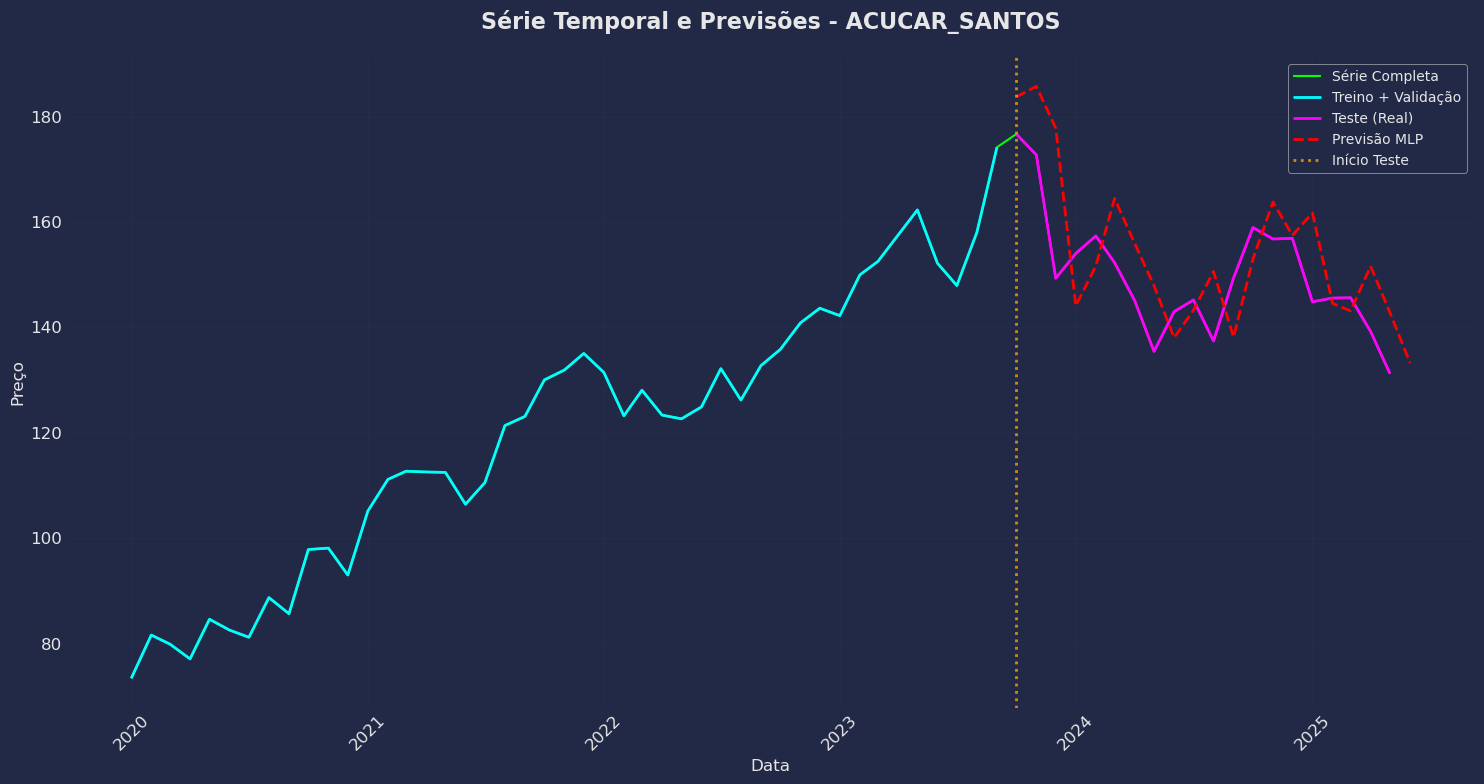

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


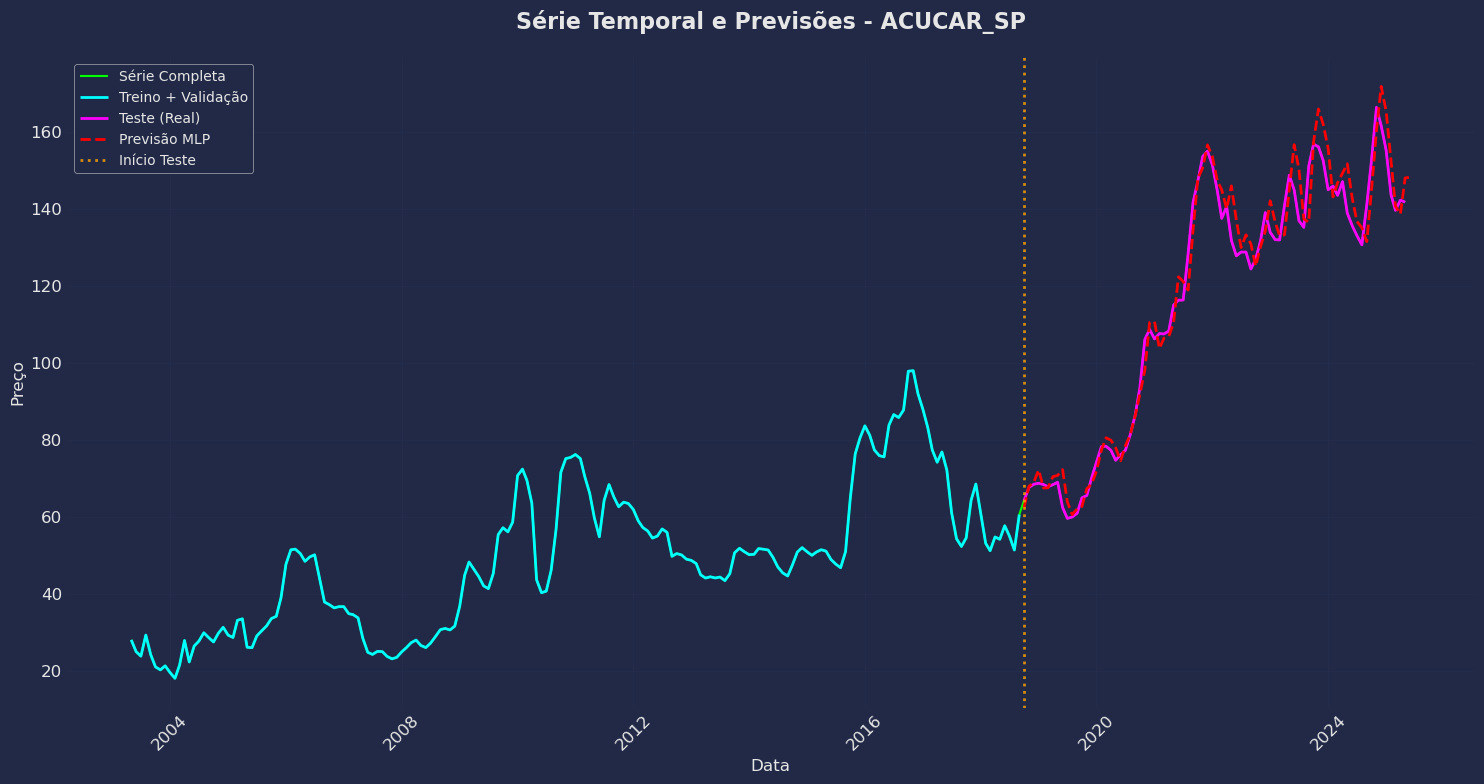

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


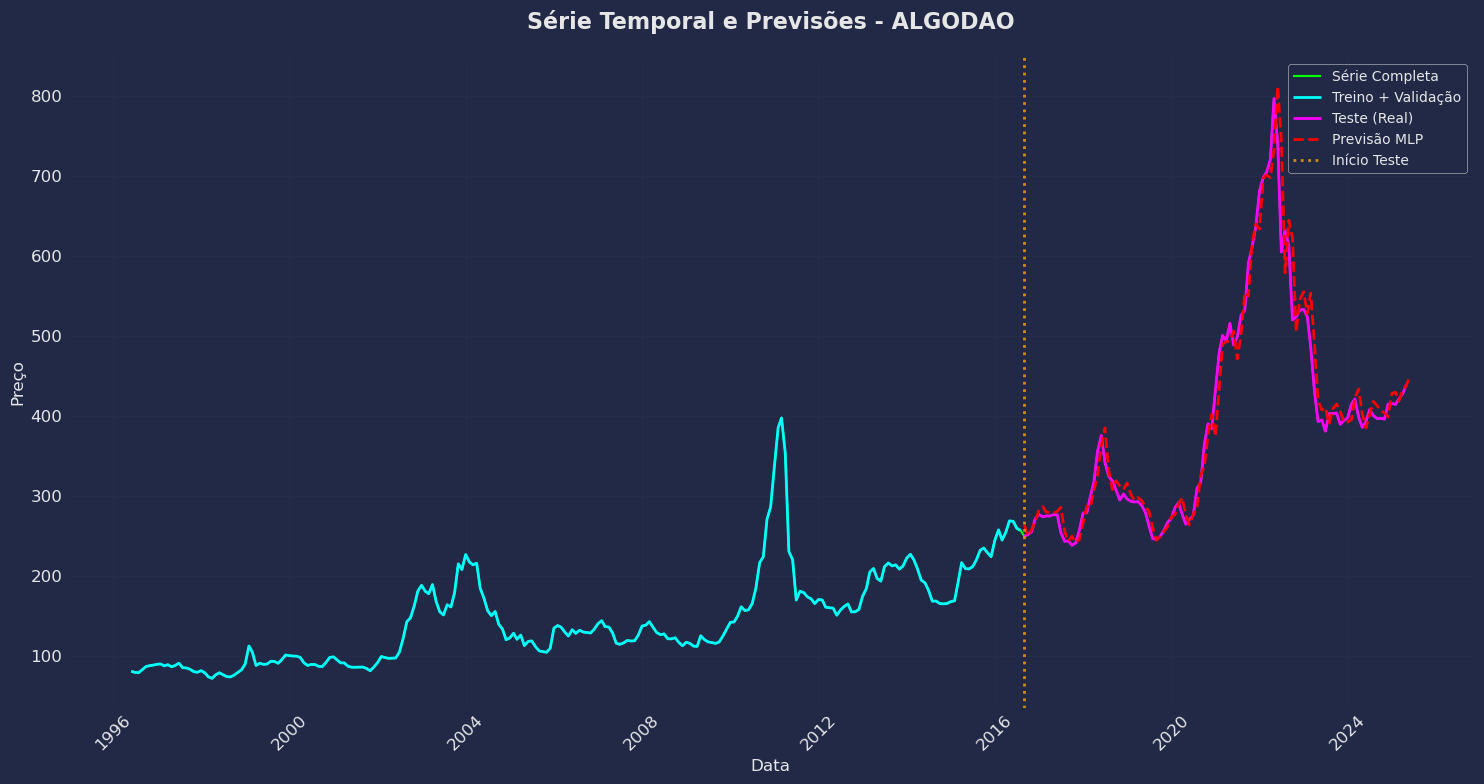

Gráfico exibido para: ALGODAO
--------------------------------------------------


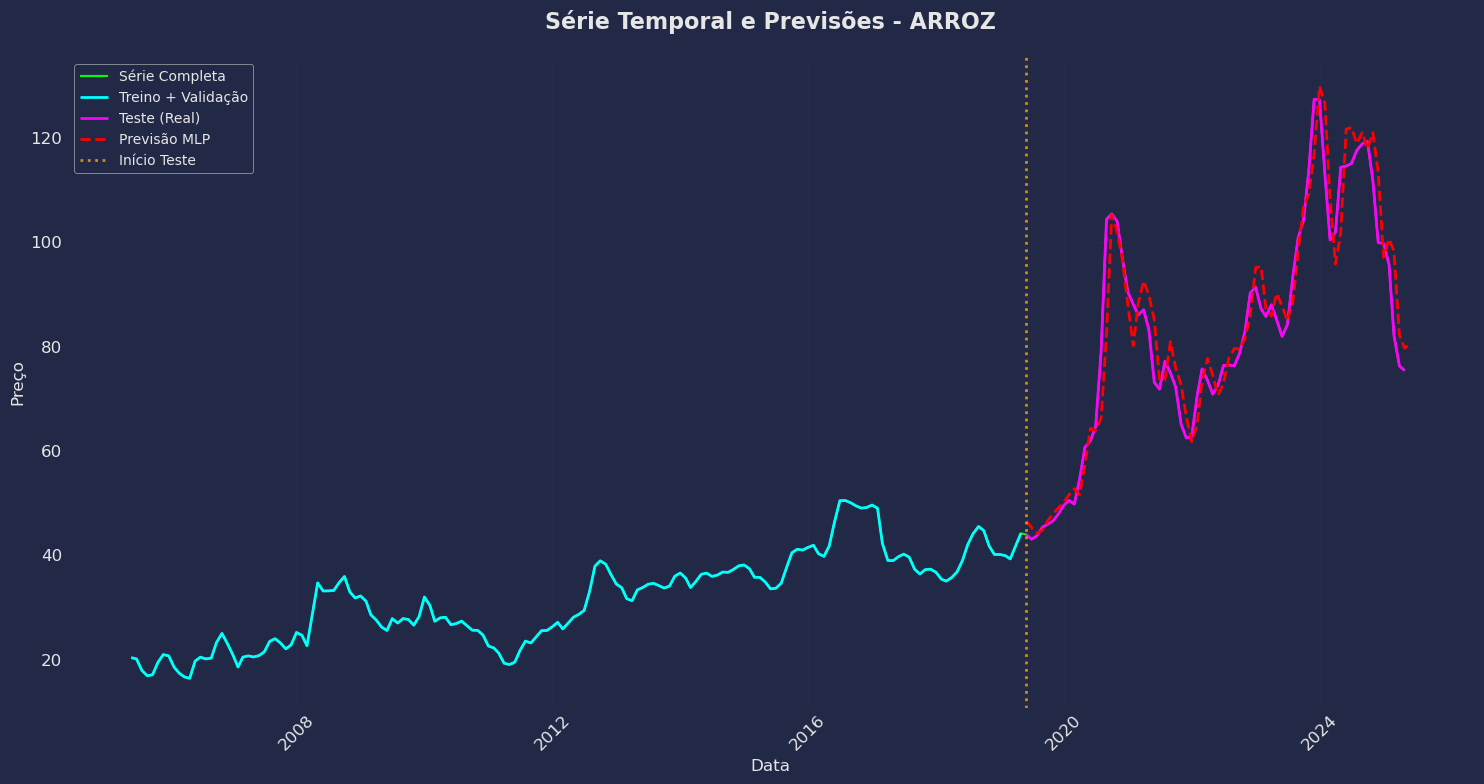

Gráfico exibido para: ARROZ
--------------------------------------------------


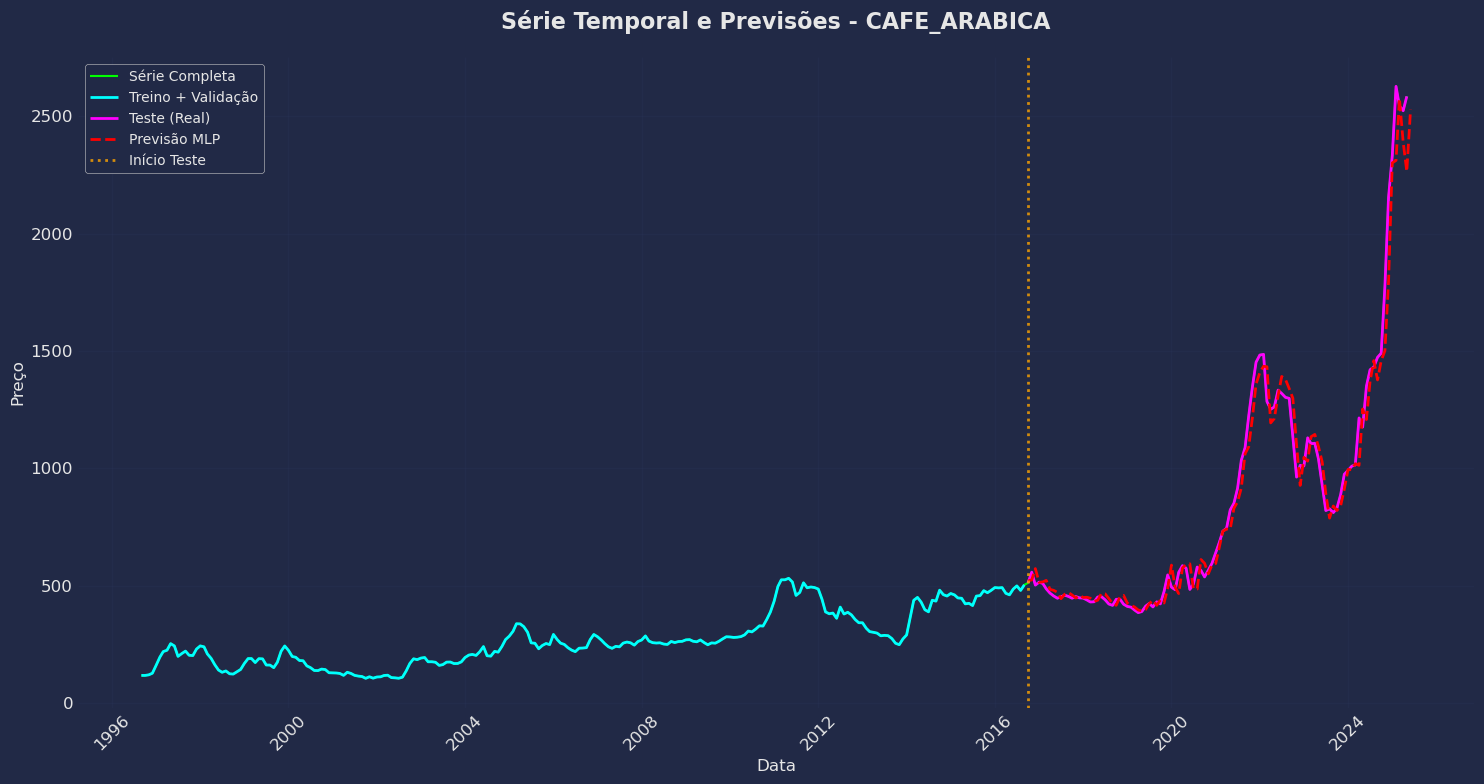

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


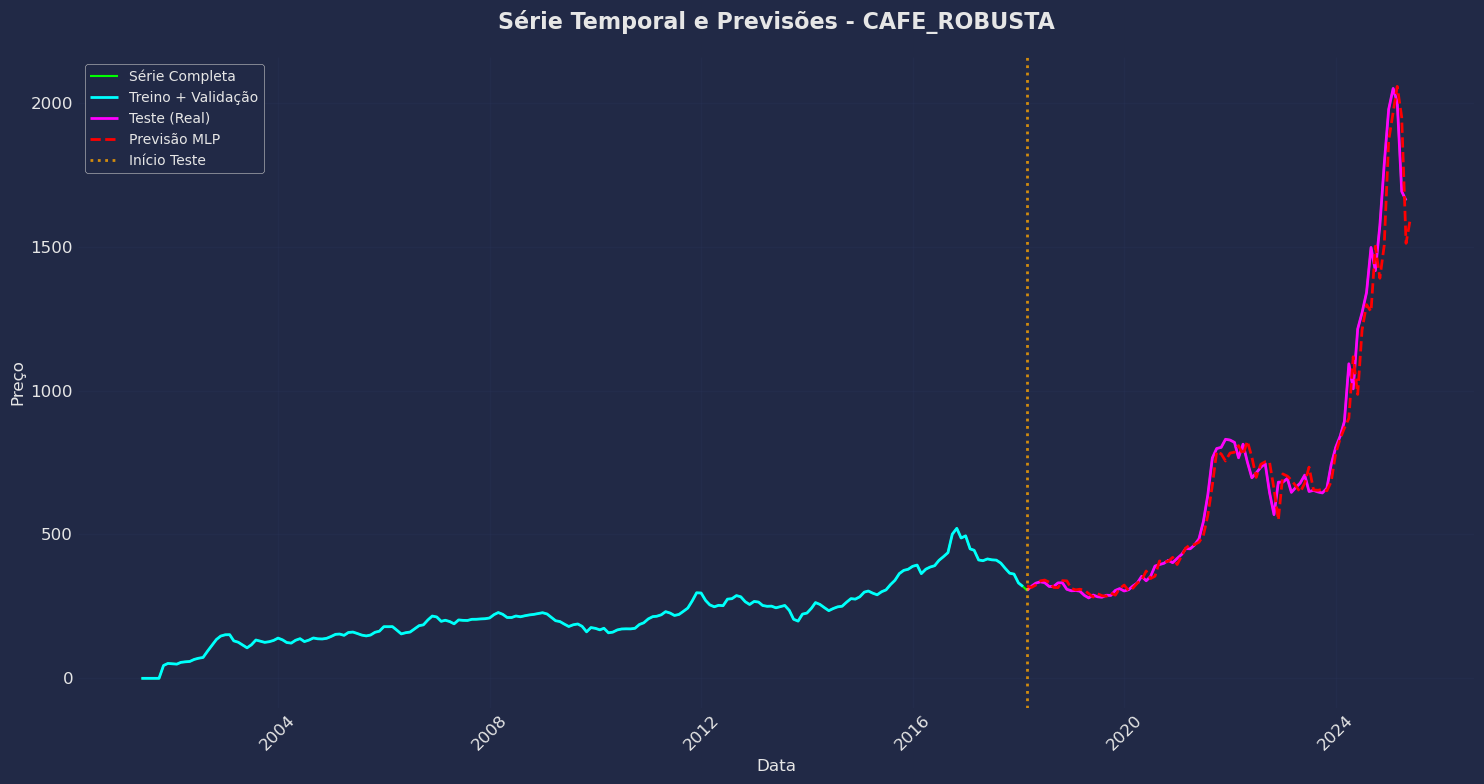

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


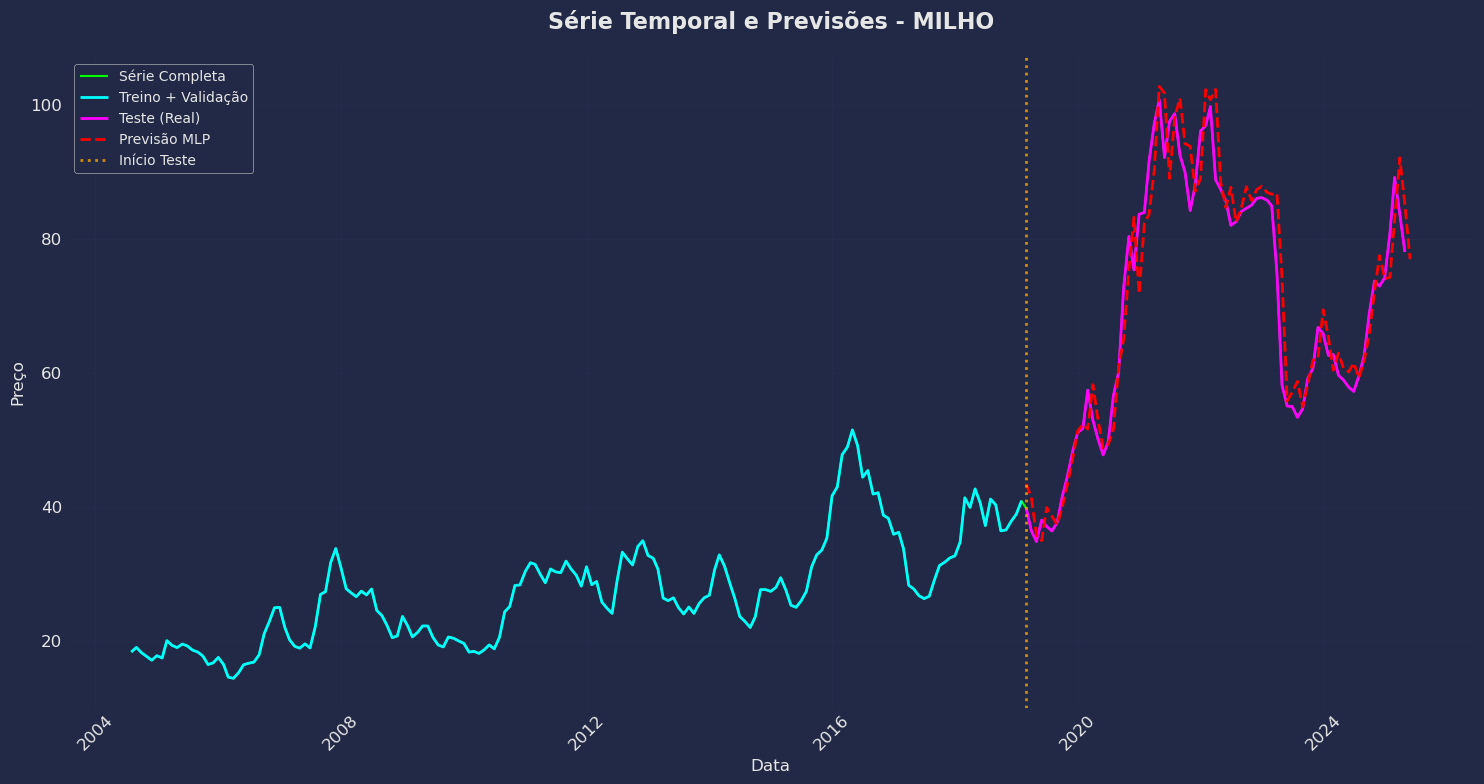

Gráfico exibido para: MILHO
--------------------------------------------------


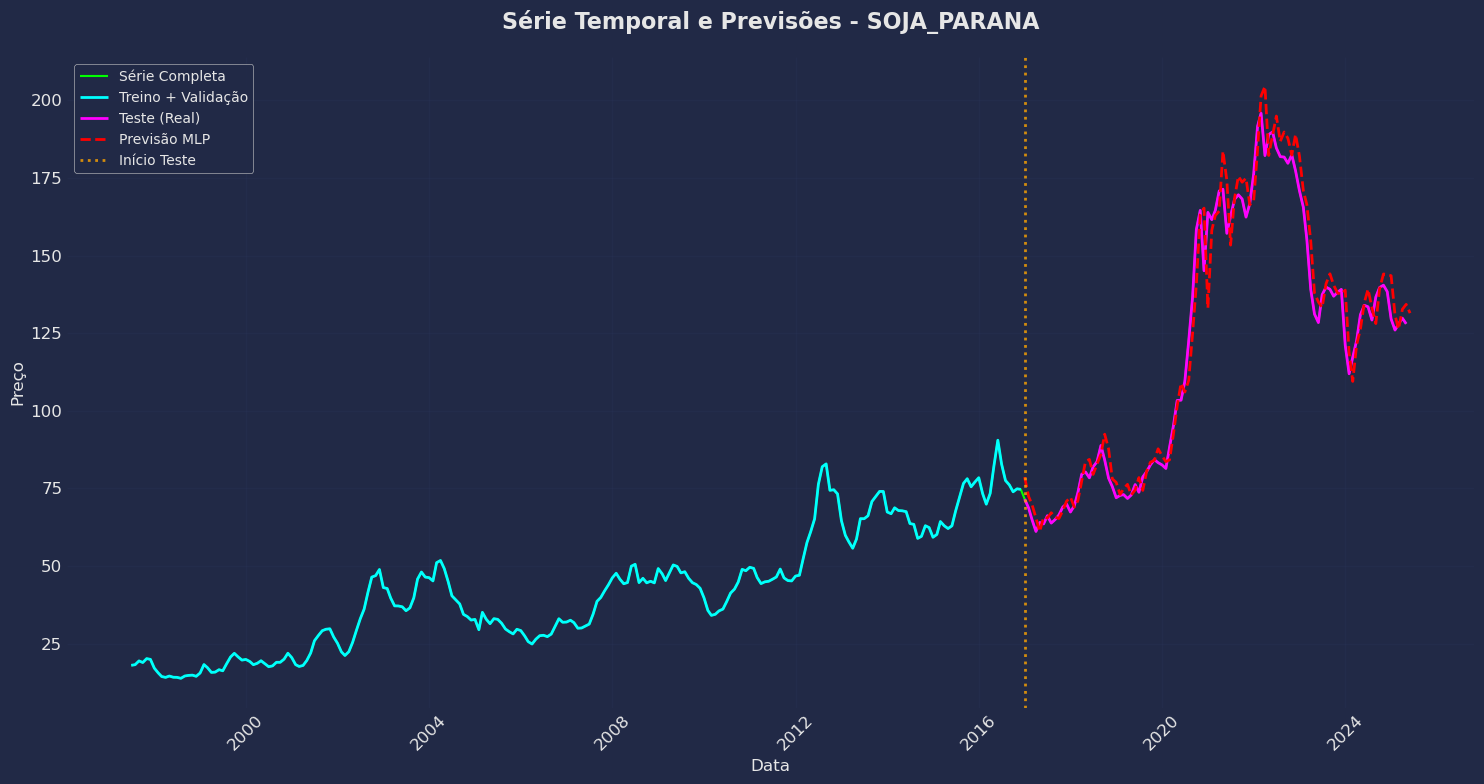

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


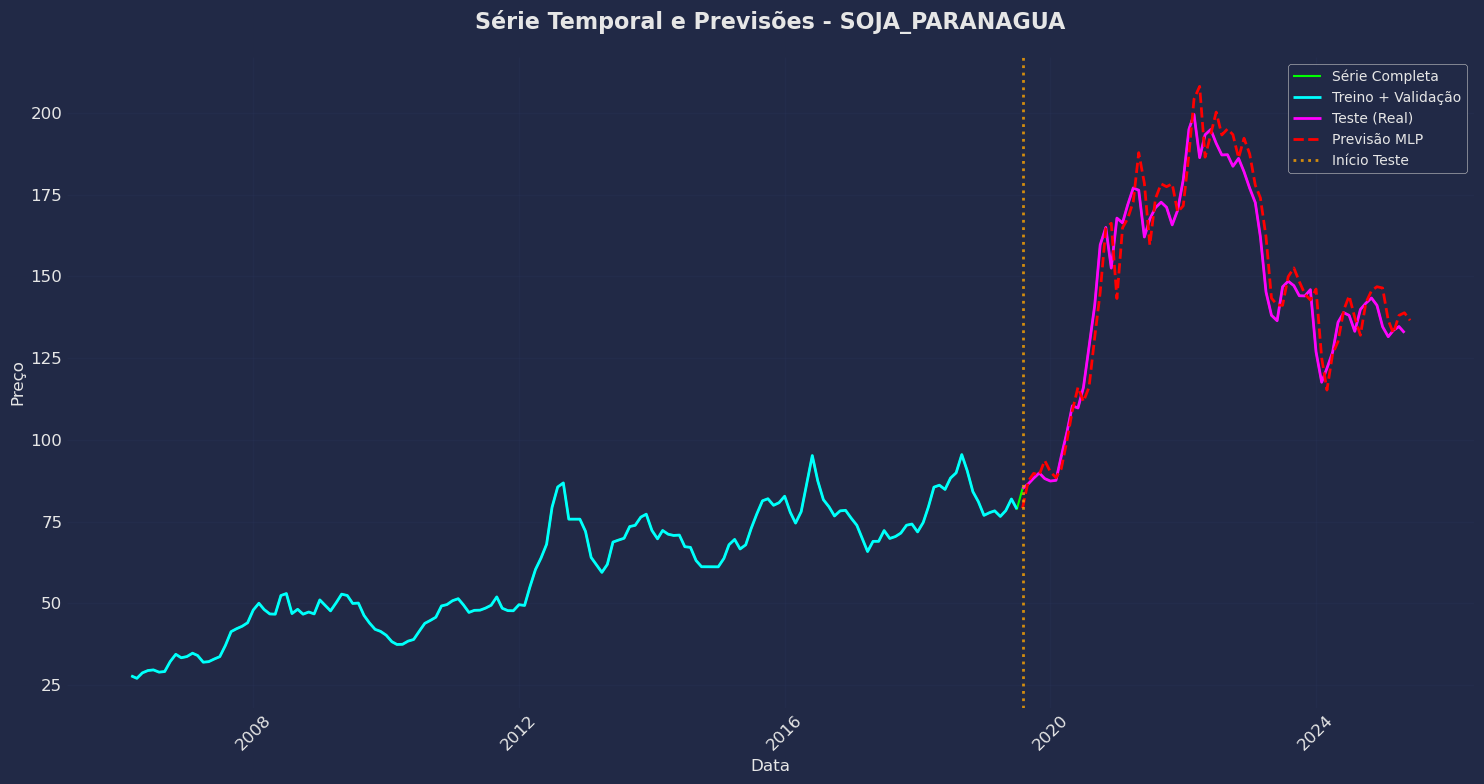

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


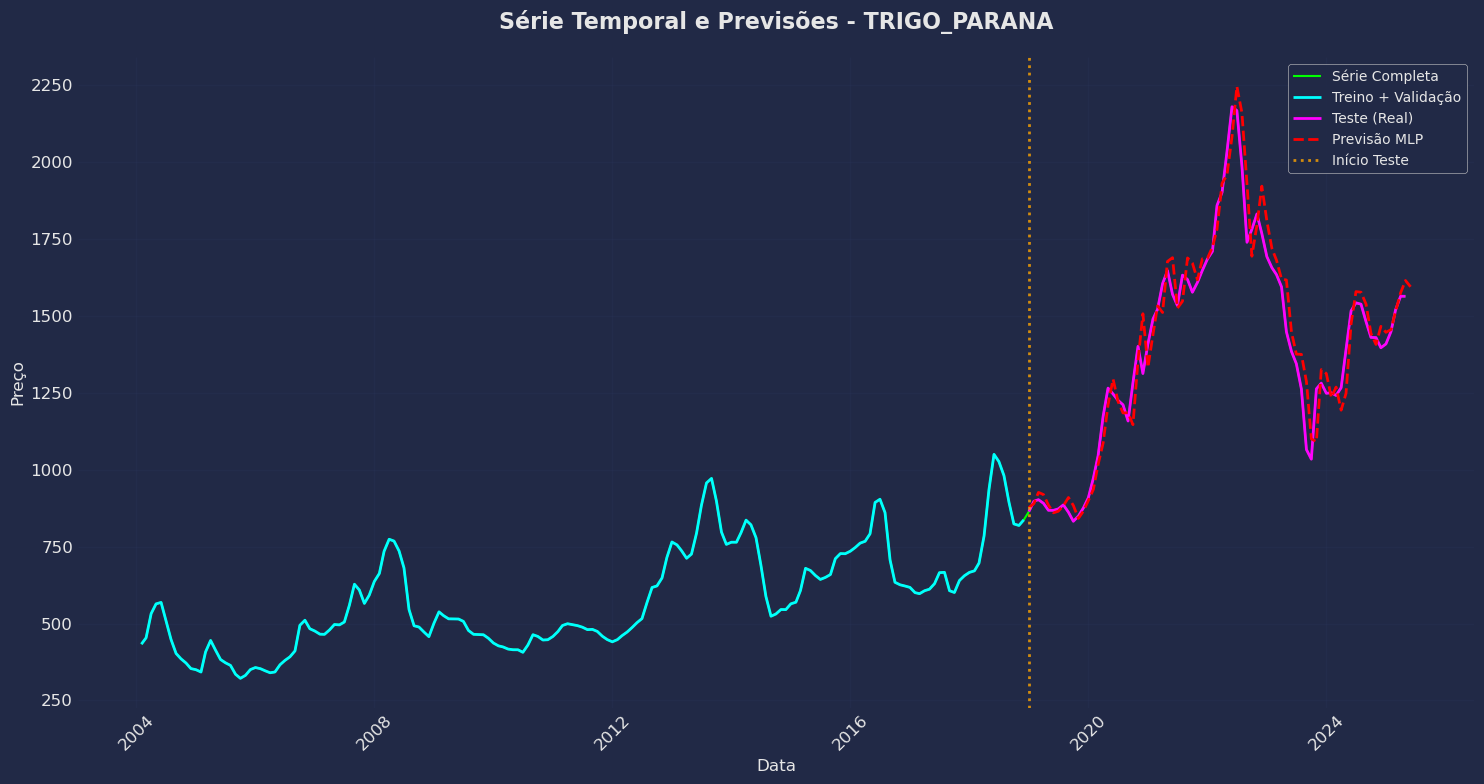

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


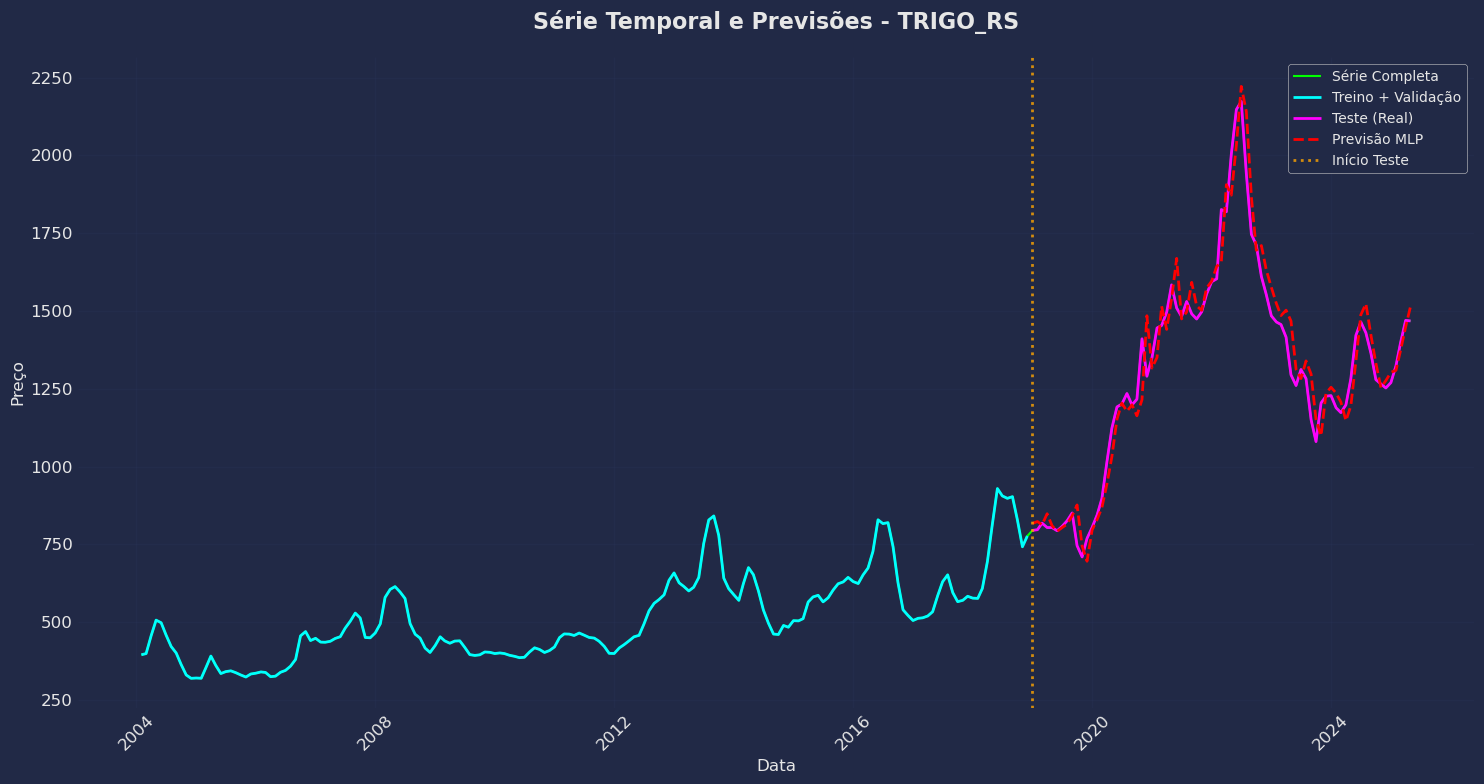

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [45]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    """
    Plota a série completa e as previsões para cada commodity individualmente
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lime', linewidth=1.5, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='cyan', linewidth=2, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='fuchsia', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['mlp'], 
                color='red', linewidth=2, linestyle='--', label='Previsão MLP')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)